
# TCAM Analysis
### Authors: Sergio Andreu-Sánchez (modified by T.Sinha, A.Fernández, N.Kuzub)
#### Last updated: 13th February, 2024


In [1]:
#****************
# Load libraries
#****************

import numpy as np
import nbconvert
import seaborn as sn
import pandas as pd
from mprod import table2tensor
from mprod.dimensionality_reduction import TCAM
from sklearn.decomposition import PCA
import seaborn as sn
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
from upsetplot import UpSet
from skbio.diversity import beta_diversity
from skbio.stats.distance import permanova 

In [2]:
#****************
# Define functions
#****************

def Pseudocount(d):
    p = min(d[d>0]) / 2
    d2 = d + p
    return(d2)

def CLR_norm(x):
    d = np.array(x)
    d = Pseudocount(d)
    d = pd.DataFrame(d.astype(float), columns=list(x.columns))
    step1_1 = d.apply(np.log, axis = 0)
    step1_2 = step1_1.apply(np.average, axis = 1)
    step1_3 = step1_2.apply(np.exp)
    step2 = d.divide(step1_3, axis = 0)
    step3 = step2.apply(np.log, axis = 1)
    return(step3)
def TCA(DF):
    print("Create tensor")
    data_tensor, map1, map3 =  table2tensor(DF, missing_flag=True)
    print("Run TCA")
    tca = TCAM()
    tca_trans = tca.fit_transform(data_tensor)
    print("Generating result tables")
    tca_loadings = tca.mode2_loadings  # Obtain TCAM loadings
    tca_var = tca.explained_variance_ratio_*100 # % explained variation per TCA factor
    tca_df = pd.DataFrame(tca_trans)   # Cast TCA scores to dataframe
    tca_df.rename(index = dict(map(reversed, map1.items())) , inplace = True)    # use the inverse of map1 to denote each row 
                                   # of the TCAM scores with it's subject ID
    return(tca_trans, tca_loadings, tca_var, tca_df)
def Attach_columns(tca_df, Info, Column=["Type"] ):
    Column.append("NEXT_ID")
    To_add = Info[Column]
    To_add = To_add.drop_duplicates(keep='last')
    tca_df["NEXT_ID"] = list(tca_df.index)
    tca_df2 =tca_df.merge(To_add, on='NEXT_ID', how='left')
    return(tca_df2)

def Attach_columns_NEXT(tca_df, Info, Column=["Type"] ):
    Column.append("NEXT_ID")
    To_add = Info[Column]
    To_add = To_add.drop_duplicates(keep='last')
    tca_df["NEXT_ID"] = list(tca_df.index)
    tca_df5 =tca_df.merge(To_add, on='NEXT_ID', how='left')
    return(tca_df5)


def Check_Loads(tca_loadings, Bugs, Top=15, Axis=0, Return=False, Plot=True):
    tca_loadings = pd.DataFrame(tca_loadings, index= Bugs)
    if Plot == False: return(tca_loadings)
    import matplotlib.pyplot as plt
    sn.kdeplot(data=tca_loadings, x=Axis)
    plt.show()
    plt.clf()
    #Biggest contributors to axis
    print(tca_loadings.sort_values(Axis).iloc[0:Top, Axis])
    print("====================================")
    print(tca_loadings.sort_values(Axis, ascending=False).iloc[0:Top,Axis])
    if Return== True:
        return(tca_loadings)

def Count_NA(x):
    x = x[x.notnull()]
    return(x.shape[0])    

def Quantify_Availability(Info, Recoded_time, Keep = [12]):
#    Info["Timepoint_numeric"] =  Recoded_time
    Time_availability = Info.pivot(index='NEXT_ID', columns='Timepoint_numeric', values='NG_ID')
    #Count total number of non-missing data
    Number_available = Time_availability.apply(Count_NA, axis=0)
    
    #Filter according to keep
    Times_keep = Time_availability[Keep]
    Times_keep = Times_keep.dropna()
    
    Time_availability[ Time_availability.notnull() ] = True
    Time_availability[ Time_availability.isnull() ] = False
    
    #UpSet Plot
    Time_availability = Time_availability.reset_index()
    Time_availability.set_index( sorted(set(Recoded_time) ) , inplace=True)
    plt = UpSet(Time_availability, subset_size='count',  show_counts=True).plot()
    
    return(Times_keep)

def Cluster(tca_var, tca_df, N_components=2, N_clusters=2 ):
    import matplotlib.pyplot as plt
    print( "Total variability explained: " + str( round(tca_var[0:N_components].sum(), 2) ) + "%" )
    linkage_data = linkage(tca_df.iloc[:,0:N_components] , method='ward', metric='euclidean')
    dendrogram(linkage_data)
    plt.show()
    plt.clf()
    
    hierarchical_cluster = AgglomerativeClustering(n_clusters=N_clusters, affinity='euclidean', linkage='ward')
    labels = hierarchical_cluster.fit_predict(tca_df.iloc[:,0:N_components])
    
    tca_df["Cluster"] = list(labels)
    fig = sn.scatterplot(data=tca_df, x=0, y=1, hue="Cluster")
    fig.set(xlabel= 'Axis 1 ({Perc}%)'.format(Perc=round(tca_var[0],2)), ylabel='Axis 2 ({Perc}%)'.format(Perc=round(tca_var[1],2)) )
    plt.show()
    plt.clf()
    
    return(tca_df)

def Plot_abundances_vs_time(tca_df, Info, DF, Bugs_plot):
    import matplotlib.pyplot as plt
    To_merge = tca_df.reset_index(drop=False)
    To_merge = To_merge[["index", "Cluster"]]
    To_merge = To_merge.rename(columns={"index": "NEXT_ID"})
    Info_clusters =Info.merge(To_merge, on='NEXT_ID', how='left')
    Info_clusters = Info_clusters.dropna()
    DF["Cluster"] = list(Info_clusters["Cluster"])
    for Bug in Bugs_plot:
        Bug_abundance = DF[[Bug, "Cluster"]]
        Bug_abundance = Bug_abundance.reset_index(drop=False)
        Bug_short = Bug.split("|s__")[-1]
        fig = sn.boxplot(data=Bug_abundance, y=Bug, x="Timepoint", hue="Cluster", )
        #fig.map(sn.swarmplot, Bug, 'Timepoint')
        #fig.set_ylim( Bug_abundance[Bug].min() , Bug_abundance[Bug].max() )
        fig.set(ylabel=Bug_short + " (Clr)")
        fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        plt.clf()

def Do_permanova(Phenos, Pheno_list, tca_df,Perm=2000):
    Results_permanova = {}
    for Pheno in Pheno_list:
        To_add = Phenos[ ["NEXT_ID", Pheno] ]
        To_add = To_add.dropna()
        To_add = To_add.astype({"NEXT_ID": str}, errors='raise') 
        To_add = To_add.set_index("NEXT_ID", drop=True)

        #Remove missing variables
        Not_Missing = []
        for i in list(tca_df.index):
            if i  in list(To_add.index): Not_Missing.append(i)   
        For_distance = tca_df.loc[ Not_Missing ]
        Distance = beta_diversity(metric = 'sqeuclidean', counts =For_distance, ids= For_distance.index)
   
        try:  
            Result = permanova(Distance, To_add, column=Pheno, permutations=Perm)
            P = Result["p-value"]
            Results_permanova[Pheno] = P
        except:
            Results_permanova[Pheno] = np.nan
    return(Results_permanova)

In [3]:
#********************************
# 0. Preprocessing of the data
#********************************

# Info - df; 
# DF - metaphlan out; 
# Type_to_drop - mother/infant; the opposite of interest
# timepoints: list with the timepoints of interest; 
# timepoint_count - how many timepoints selected

def Do_preprocessing(Info, DF, Type_to_drop, timepoints, timepoint_count):
    Info['NG_ID'] = Info.index  # create the column "NG_ID" (for comparability with the original data)
    Info.reset_index(drop=True, inplace=True)  # drop the row names (for comparability with the original data)
    Info['NEXT_ID'] = Info['Family'].str.replace('FAM', 'NEXT')  # create the column NEXT_ID for the test dataset
    Info = Info.drop(columns=["Binary_phenotype_dynamic", "Factor_phenotype_dynamic", "Quant_phenotype_dynamic", "Covariate1", "Covariate2"])  # Drop dynamic phenotypes: only static phenotypes can be used for the analysis
    Info = Info.drop(Info[Info['Type'] == Type_to_drop].index)
    Info = Info[Info['Timepoint'].isin(timepoints)]
    next_id_counts = Info['NEXT_ID'].value_counts()
    Info['NEXT_ID_count'] = Info['NEXT_ID'].map(next_id_counts)
    Info = Info[Info['NEXT_ID_count'] >= timepoint_count]
    Info = Info.drop(columns=['NEXT_ID_count'])

    DF = DF[DF.index.isin(Info.NG_ID)].copy()  # Filter rows based on index being in Info.NG_ID
    DF.loc[:, 'ID'] = DF.index  # Add sample IDs as a column
    DF.index.names = [None]

    # Start filtering: filter out the bacteria which have a relative abundance of more than 0.01% in at least 5 individuals
    filt_DF = DF.copy(deep=True)
    filt_DF = filt_DF.drop(columns=['ID'])
    filt_DF.loc[:, 'NEXT_ID'] = Info.set_index('NG_ID').loc[filt_DF.index, 'NEXT_ID']
    columns_to_filter = filt_DF.columns[filt_DF.columns != 'NEXT_ID']
    non_zero_rows = filt_DF.loc[:, columns_to_filter].where(filt_DF[columns_to_filter] > 0.0001)
    next_id_column = filt_DF[['NEXT_ID']]
    non_zero_rows = pd.concat([next_id_column, non_zero_rows], axis=1)
    result = non_zero_rows.groupby('NEXT_ID').nunique()
    result = result.applymap(lambda x: 1 if x != 0 else 0)
    unique_counts = result.sum()
    unique_counts = pd.Series(unique_counts, index=result.columns)
    selected_columns = ['ID'] + unique_counts[unique_counts >= 3].index.tolist()
    DF = DF.loc[:, selected_columns]

    
    # Giving the order of the levels of the categorical variable; the order of the levels is the order that we have in Info df
    DF['ID'] = DF['ID'].astype("category").cat.set_categories(Info.NG_ID)
    DF = DF.sort_values(["ID"])
    DF2 = DF.drop(["ID"], axis=1)
    DF2 = CLR_norm(DF2)
    
    
    # Add "NEXT_ID", "Timepoint_numeric" variables to the CLR transformed abundance table
    timepoint_mapping = {'M1': 4, 'M3': 12, 'P12': -28, 'P28': -12, 'B': 0, 'M6': 24, 'M12': 48, 'W2': 2}
    Info['Timepoint_numeric'] = Info['Timepoint'].map(timepoint_mapping)
    Info2 = Info[["NEXT_ID", "Timepoint_numeric"]]
    DF3 = pd.concat([Info2.reset_index(drop=True), DF2.reset_index(drop=True)], axis=1)
    # Generate a multi-index on the abundance table based on'NEXT_ID' and 'Timepoint_numeric' variables
    Arrays = [ list(DF3.NEXT_ID), list(DF3.Timepoint_numeric) ]
    tuples = list(zip(*Arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=["NEXT_ID", "Timepoint_numeric"])
    DF3.index = index
    DF3 =DF3.drop(["NEXT_ID", "Timepoint_numeric"], axis=1)
    return(DF3)

Info = pd.read_csv("./simulated_metadata.txt", sep="\t")
DF = pd.read_csv("./simulated_metaphlan.txt", sep="\t")

infant_W2_M1_M3 = Do_preprocessing(Info, DF, "mother", ['W2', 'M1', 'M3'], 3)  # infant sample subset with 3 avaliable timepoints

In [4]:
#********************************
# 1. Perform TCA analysis
#********************************

# getting the transformed data, loadings, explained variance, and transformed data (one row per individual) here
tca_trans_infant_W2_M1_M3, tca_loadings_infant_W2_M1_M3, tca_var_infant_W2_M1_M3, tca_df_infant_W2_M1_M3 = TCA(infant_W2_M1_M3)   # early timepoints

Create tensor
Run TCA
Generating result tables


[Text(0.5, 0, 'Axis 1 (0.46%)'), Text(0, 0.5, 'Axis 2 (0.45%)')]

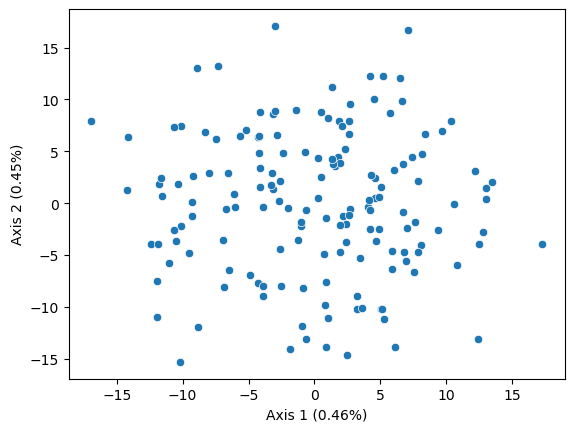

In [5]:
#********************************
# 2. Generate the plots
#********************************

fig_infant_W2_M1_M3 = sn.scatterplot(data=tca_df_infant_W2_M1_M3, x=0, y=1)
fig_infant_W2_M1_M3.set(xlabel= 'Axis 1 ({Perc}%)'.format(Perc=round(tca_var_infant_W2_M1_M3[0],2)), ylabel='Axis 2 ({Perc}%)'.format(Perc=round(tca_var_infant_W2_M1_M3[1],2)) )

In [6]:
#****************
#3. Save output
#****************
tca_df_infant_W2_M1_M3.to_csv("TCAM_infant_W2_M1_M3.txt")
pd.DataFrame(tca_loadings_infant_W2_M1_M3).set_index(infant_W2_M1_M3.columns).to_csv("TCAM_loadings_infant_W2_M1_M3.txt")
pd.DataFrame(tca_var_infant_W2_M1_M3).to_csv("TCAM_variance_expl_infant_W2_M1_M3.txt")